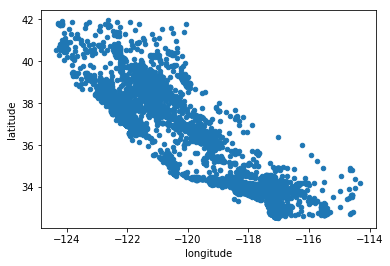

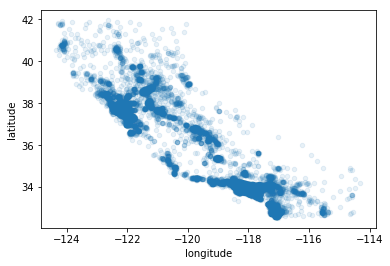

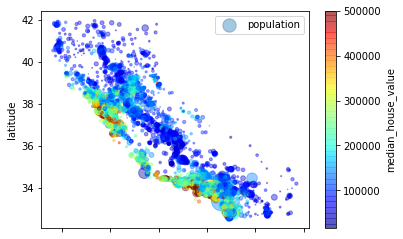

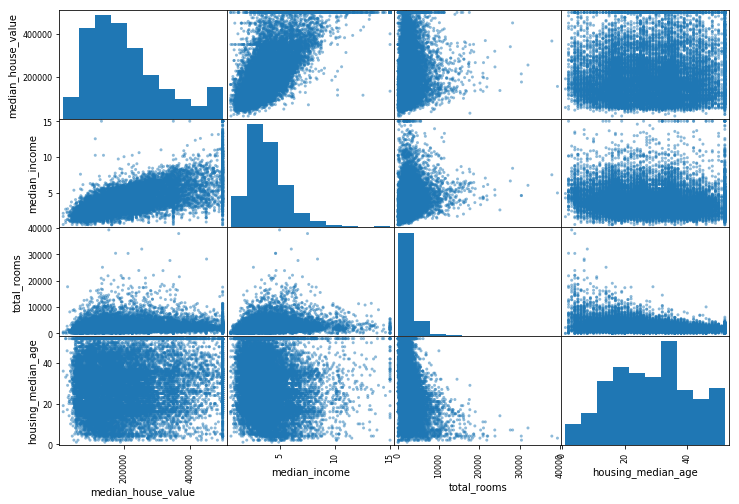

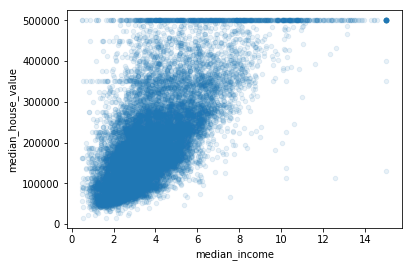

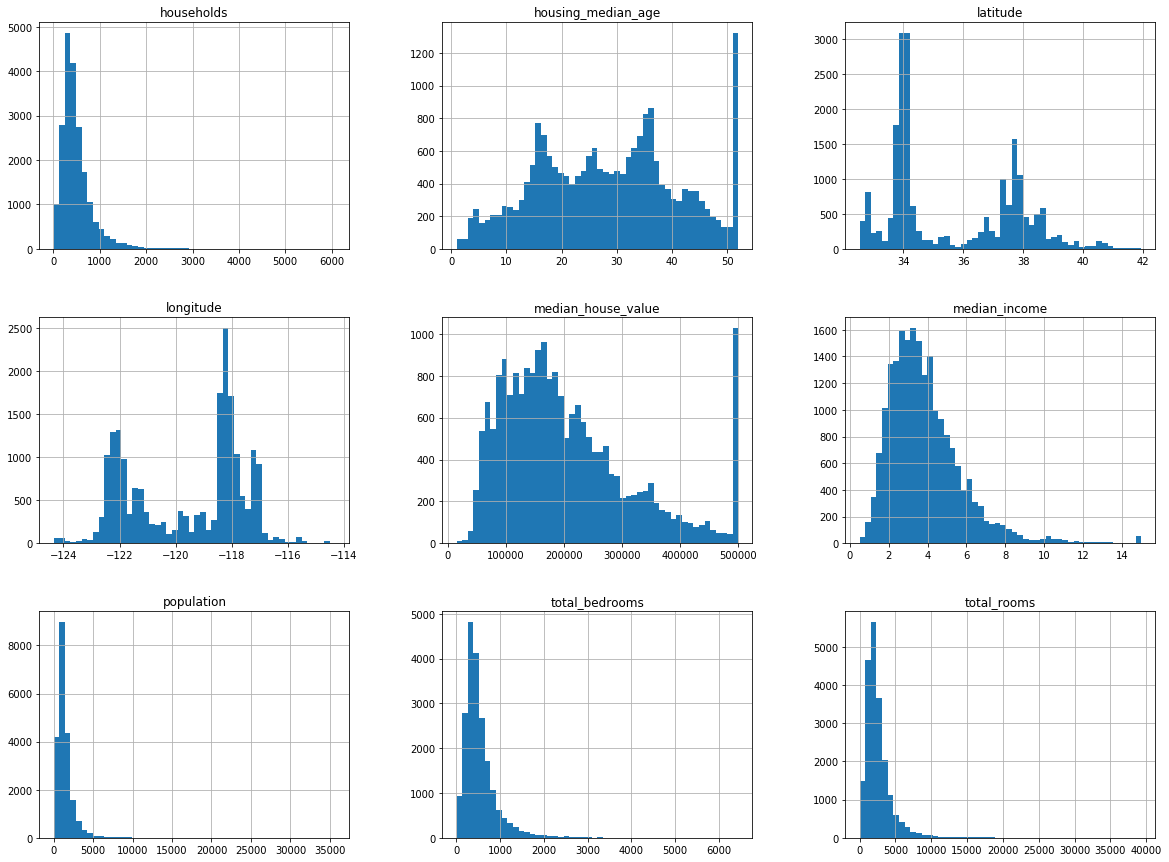

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


[0 0 4 ..., 1 0 3]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 ..., 
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]


NameError: name 'self' is not defined

In [15]:
import os
import tarfile
from six.moves import urllib
import csv

DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH="datasets/housing"
HOUSING_URL=DOWNLOAD_ROOT+HOUSING_PATH+"/housing.csv"

def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path=os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close
    
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path=os.path.join("https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing", "housing.csv")
    return pd.read_csv(csv_path)

housing=load_housing_data()
#print (housing.head())

#print (housing.info())

#housing["ocean_proximity"].value_counts()

#print (housing.describe())

import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

import hashlib
import numpy as np
"""def split_train_test(data, test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data))*test_ratio
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set=split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")"""

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1]<256*test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids=data[id_column]
    in_test_set=ids.apply(lambda id_:test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id=housing.reset_index() #adds an index column
train_set,test_set=split_train_test_by_id(housing_with_id, 0.2, "index")

housing_with_id["id"]=housing["longitude"]*1000+housing["latitude"]
train_set,test_set=split_train_test_by_id(housing_with_id, 0.2, "id")

from sklearn.model_selection import train_test_split
train_set, test_set=train_test_split(housing, test_size=0.2, random_state=42)

"""stratified sampling: sampling to represent a population at large for how
it is, as opposed to random sampling"""

housing["income_cat"]=np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)

#use Stratified Split to do this
from sklearn.model_selection import StratifiedShuffleSplit

split=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]
    
housing["income_cat"].value_counts()/len(housing)

for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)
    
#make a copy of the train set to not harm the original
housing=strat_train_set.copy()

import matplotlib.pyplot as plt
housing.plot(kind="scatter", x="longitude", y="latitude")
####plt.show()

#set alpha option to make high-density areas clearer

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
#######plt.show()

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
###########plt.show()

corr_matrix=housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

from pandas.tools.plotting import scatter_matrix
attributes=["median_house_value", "median_income", "total_rooms",
           "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

#zoom in on median housing value
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1)

#comparing other attributes of each house
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

#Using Machine Learning algorithms; revert to clean train set
housing=strat_train_set.drop("median_house_value", axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

#Get rid of corresponding districts
housing.dropna(subset=["total_bedrooms"])
from sklearn.preprocessing import Imputer
imputer=Imputer(strategy="median")

#get rid of text attribute, since median can only be computed on numbers
housing_num=housing.drop("ocean_proximity", axis=1)
#fit imputer instance to training data
imputer.fit(housing_num)

imputer.statistics_
housing_num.median().values
X=imputer.transform(housing_num)
#the result is in numpy, convert to pd DataFrame:
housing_tr=pd.DataFrame(X, columns=housing_num.columns)

#converting text labels to numbers
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
housing_cat=housing["ocean_proximity"]
housing_cat_encoded=encoder.fit_transform(housing_cat)
print (housing_cat_encoded)

print (encoder.classes_)

#making the text scales a binary option
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder()
housing_cat_1hot=encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
#storing 1's as a sparse matrix, ignoring 0's
housing_cat_1hot.toarray()
from sklearn.preprocessing import LabelBinarizer
encoder=LabelBinarizer()
housing_cat_1hot=encoder.fit_transform(housing_cat)
print(housing_cat_1hot)

#creating custom transformers
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix=3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def _init_(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household=X[:, rooms_ix]/X[:, household_ix]
        population_per_household=X[:, population_ix]/x[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room=X[:, bedrooms_ix]/ X[:, household_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder=CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs=attr_adder.transform(housing.values)


